In [1]:
# Start writing code here...
import numpy as np 
import pandas as pd
import nltk

pd.options.mode.chained_assignment = None 

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tag import pos_tag
import os, re
import json
import matplotlib.pyplot as plt

import nltk
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
  
import seaborn as sns
sns.set_style('whitegrid')
    
from IPython.display import display, clear_output
    
from tqdm import tqdm
import string

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')

tqdm.pandas()

In [2]:
TRAIN_SPLIT = 0.9
SENTENCES_TO_EXTRACT = 10
DROP_FRAC = 0.8

In [3]:
train_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
sample_sub = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')

train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_files_path = '../input/coleridgeinitiative-show-us-the-data/test'

In [4]:
create_text_ds = True

try:
    CSV_PATH = "../input/colerigde-processed-text/text.csv"
    pd.read_csv(CSV_PATH)
    create_text_ds = False
except:
    print("No text dataset")
    CSV_PATH = 'text.csv'

In [5]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


In [6]:
grouped_df = pd.DataFrame(train_df['dataset_label'].value_counts())
grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.sort_values(by="dataset_label", ascending=False)
grouped_df.head()

,index,dataset_label
0,ADNI,3673
1,Alzheimer's Disease Neuroimaging Initiative (A...,2400
2,Trends in International Mathematics and Scienc...,1163
3,Baltimore Longitudinal Study of Aging,1156
4,Early Childhood Longitudinal Study,1011


In [7]:
grouped_df = grouped_df.iloc[0:25]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


[]

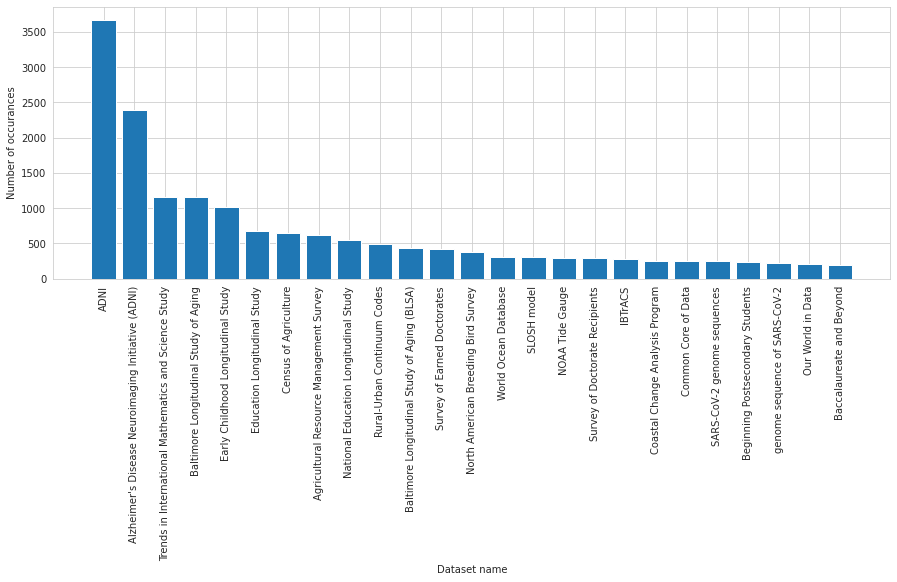

In [8]:
fig, ax = plt.subplots(figsize=(15,5))

ax.bar(grouped_df['index'].values, grouped_df['dataset_label'].values)
ax.set_xticklabels(labels=grouped_df['index'].values,rotation=90);
ax.set_ylabel("Number of occurances")
ax.set_xlabel("Dataset name")

plt.plot()

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19661 entries, 0 to 19660
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             19661 non-null  object
 1   pub_title      19661 non-null  object
 2   dataset_title  19661 non-null  object
 3   dataset_label  19661 non-null  object
 4   cleaned_label  19661 non-null  object
dtypes: object(5)
memory usage: 768.1+ KB


In [10]:
sample_sub.head()

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,NaN
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN


In [11]:
print("Nr. of unique labels: {}".format(len(train_df['cleaned_label'].unique())))

Nr. of unique labels: 130


In [12]:
# Check for missing values
train_df.isna().sum()

Id               0
pub_title        0
dataset_title    0
dataset_label    0
cleaned_label    0
dtype: int64

In [13]:
nr_train_csv_ids = train_df['Id'].count()
nr_unique_train_csv_ids = train_df['Id'].nunique()
nr_train_files = len([name for name in os.listdir(train_files_path) if os.path.isfile(os.path.join(train_files_path, name))])

# Confirm that we have as many rows in the train.csv file as that we have files in the train.csv folder?
print("Data in train.csv file: {}".format(nr_train_csv_ids))
print("\n")
print("Unique data in train.csv file: {}".format(nr_unique_train_csv_ids))
print("Data in train folders: {}".format(nr_train_files))
print("\n")
print("Avg. nr. of sources per publication: {}".format(nr_train_csv_ids/nr_unique_train_csv_ids))

assert nr_unique_train_csv_ids == nr_train_files

Data in train.csv file: 19661


Unique data in train.csv file: 14316
Data in train folders: 14316


Avg. nr. of sources per publication: 1.3733584800223526


In [14]:
stopwords = []
with open("../input/stopwords/stopwords.txt", "r") as fd:
    stopwords = fd.read().splitlines()

print(stopwords)

['a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 'against', 'ah', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apparently', 'approximately', 'are', 'aren', 'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 'at', 'auth', 'available', 'away', 'awfully', 'b', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'begin', 'beginning', 'beginnings', 'begins', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'between', 'beyond', 'biol', 'both', 'brief', 'briefly', 'but', 'by', 'c', 'ca', 'came', 'can', 'cannot', "can't", 'cause', 'causes', 'certain', 'certainly', 'co', 'com', 'come', 'comes', 'cont

In [15]:
words =list(train_df.values)
split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

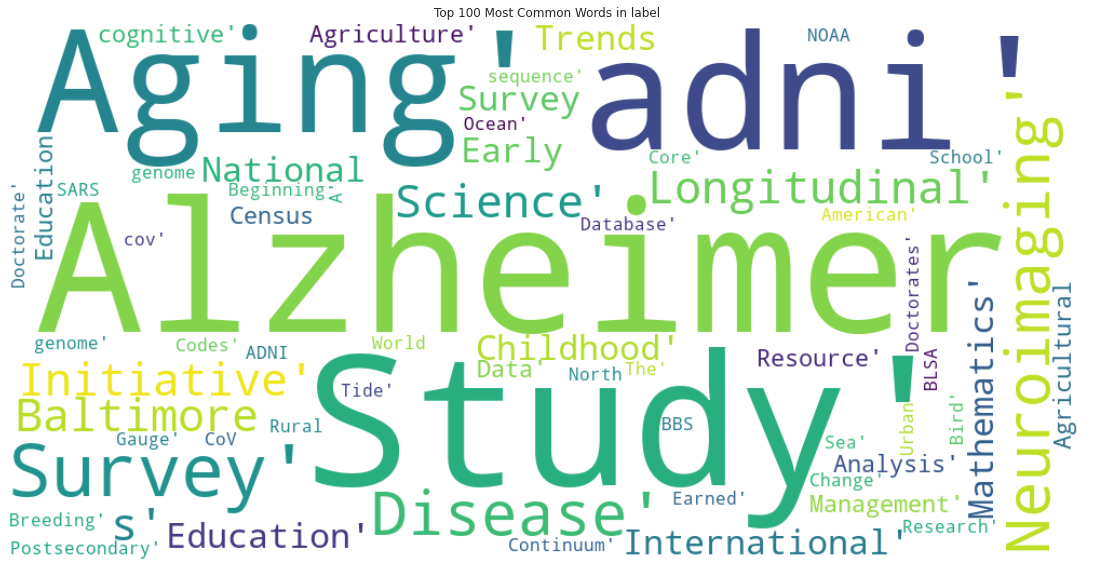

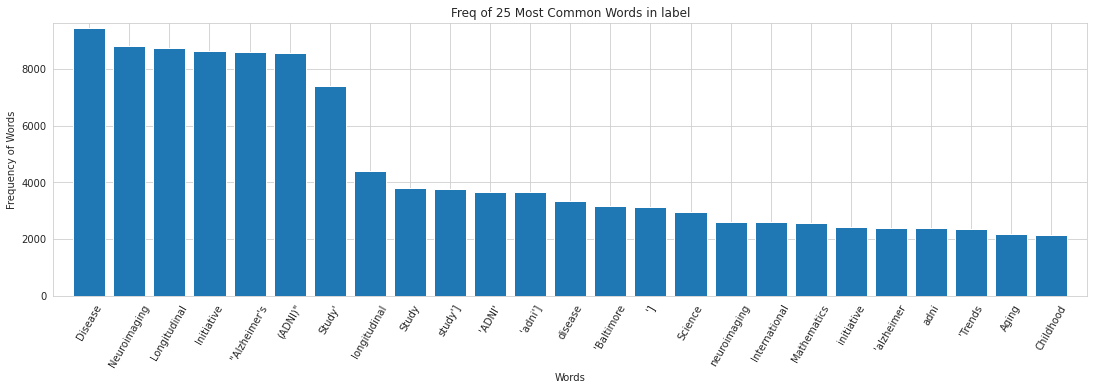

In [16]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1000, height=500, background_color='white', stopwords=STOPWORDS).generate(str(mostcommon))
fig = plt.figure(figsize=(15,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in label')
plt.tight_layout(pad=0)
plt.show()

mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15,5))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.xticks(rotation=60)
plt.tight_layout(pad=0)
plt.title('Freq of 25 Most Common Words in label')
plt.show()

In [17]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


## Retrieve document from random publication Id

In [18]:
pub_id = np.random.choice(train_df['Id'].unique())
pub_title = train_df[train_df["Id"] == pub_id].pub_title
pub_df = pd.read_json(train_files_path+"/"+str(pub_id)+".json")

print("Random publication ID: {}".format(pub_id))
print("Random publication name: {}".format(pub_title))
print("\n")

pub_df.head()

Random publication ID: 4f49ba3c-f1a3-47d1-9f9b-d17c43867a42
Random publication name: 4531    Alzheimer ' s disease progression in 1309 MRI ...
9738    Alzheimer ' s disease progression in 1309 MRI ...
Name: pub_title, dtype: object




,section_title,text
0,Abstract,Neuroimaging centers and pharmaceutical compan...
1,Introduction,Alzheimer's disease (AD) is a pathological con...
2,Materials and methods,
3,Subjects,Longitudinal brain MRI scans and associated cl...
4,MRI acquisition and image correction,All subjects were scanned with a standardized ...


In [19]:
train_df[train_df["Id"] == pub_id]

,Id,pub_title,dataset_title,dataset_label,cleaned_label
4531,4f49ba3c-f1a3-47d1-9f9b-d17c43867a42,Alzheimer ' s disease progression in 1309 MRI ...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni
9738,4f49ba3c-f1a3-47d1-9f9b-d17c43867a42,Alzheimer ' s disease progression in 1309 MRI ...,Alzheimer's Disease Neuroimaging Initiative (A...,Alzheimer's Disease Neuroimaging Initiative (A...,alzheimer s disease neuroimaging initiative adni


In [20]:
pub_dataset_titles = train_df[train_df["Id"] == pub_id].dataset_title.values

print("Nr. of sections in this publication: {}".format(pub_df["section_title"].count()))
print("Datasets in this publication: {}".format(pub_dataset_titles))

Nr. of sections in this publication: 20
Datasets in this publication: ["Alzheimer's Disease Neuroimaging Initiative (ADNI)"
 "Alzheimer's Disease Neuroimaging Initiative (ADNI)"]


In [21]:
# Find sentence(s) containing dataset name
pub_df['lowercase_text'] = pub_df["text"].str.lower()

pub_df.head()

,section_title,text,lowercase_text
0,Abstract,Neuroimaging centers and pharmaceutical compan...,neuroimaging centers and pharmaceutical compan...
1,Introduction,Alzheimer's disease (AD) is a pathological con...,alzheimer's disease (ad) is a pathological con...
2,Materials and methods,,
3,Subjects,Longitudinal brain MRI scans and associated cl...,longitudinal brain mri scans and associated cl...
4,MRI acquisition and image correction,All subjects were scanned with a standardized ...,all subjects were scanned with a standardized ...


In [22]:
clean_datasets = np.array([])

for dataset in pub_dataset_titles:
    clean_datasets = np.append(clean_datasets, dataset.lower())

print(clean_datasets)

["alzheimer's disease neuroimaging initiative (adni)"
 "alzheimer's disease neuroimaging initiative (adni)"]


In [23]:
def extract_ds_sentence(text, dataset_title):
    escaped_ds_title = re.escape(dataset_title)
    return re.findall(r"([^.]*?"+re.escape(escaped_ds_title)+"[^.]*\.)",text)

## Cleaning the data

In [24]:
all_IDs = train_df['Id'].unique()

print(type(all_IDs))
all_IDs_test = all_IDs[:5000]
all_IDs_test[:10]

<class 'numpy.ndarray'>


array(['d0fa7568-7d8e-4db9-870f-f9c6f668c17b',
       '2f26f645-3dec-485d-b68d-f013c9e05e60',
       'c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29',
       '5c9a3bc9-41ba-4574-ad71-e25c1442c8af',
       'c754dec7-c5a3-4337-9892-c02158475064',
       '81b5f874-9b42-4d4f-8c50-b4bab24f8aed',
       'f35fdfa6-a3f9-4ef3-a858-c8e2efcd2349',
       '1b21f60a-4022-4b19-95ce-6fd7157d4aa9',
       'e5a4c6af-0854-4f7e-b088-06f03c18a01a',
       '4e18b1c7-e195-46e2-af0f-78757259f0c6'], dtype=object)

In [25]:
def slice_sentence(pub_id): 
    final_df = pd.DataFrame()
    path_to_pub = os.path.join(train_files_path, (pub_id+'.json'))

    sentences_col = np.array([])
    labels_col = np.array([])
    sections_col = np.array([])

    with open(path_to_pub, 'r') as f:  
        pub_df = pd.read_json(f)

    for index,row in pub_df.iterrows():
        sentences_in_section = re.findall(r"[A-Z].*?[\.!?]\s?(?=[A-Z]|$)",row["text"])
    
        for sentence in sentences_in_section:
            for label in train_df[train_df['Id'] == pub_id].dataset_label:
                if label in sentence:
                    sentences_col = np.append(sentences_col,sentence)
                    labels_col = np.append(labels_col,label)
                    sections_col = np.append(sections_col,row["section_title"])
    
    final_df["Section"] = sections_col
    final_df["Text"] = sentences_col
    final_df["Label"] = labels_col
    final_df["Id"] = pub_id
    
    return final_df

In [26]:
def slice_section(pub_id): 
    final_df = pd.DataFrame()
    path_to_pub = os.path.join(train_files_path, (pub_id+'.json'))

    text_col = np.array([])
    labels_col = np.array([])
    sections_col = np.array([])

    with open(path_to_pub, 'r') as f:  
        pub_df = pd.read_json(f)

    for index,row in pub_df.iterrows():
        for label in train_df[train_df['Id'] == pub_id].dataset_label:
            if label in row['text']:
                labels_col = np.append(labels_col,label)
                sections_col = np.append(sections_col,row["section_title"])
                text_col = np.append(text_col,row["text"])
            
    
    final_df["Section"] = sections_col
    final_df["Text"] = text_col
    final_df["Label"] = labels_col
    final_df["Id"] = pub_id
    
    return final_df

In [27]:
slice_section(all_IDs[13])

,Section,Text,Label,Id
0,Abstract,This study examines two important and related ...,National Education Longitudinal Study,e977a870-0067-4221-8423-5ff349510222
1,Abstract,This study examines two important and related ...,Education Longitudinal Study,e977a870-0067-4221-8423-5ff349510222
2,Introduction,When then-Harvard President Lawrence Summers p...,National Education Longitudinal Study,e977a870-0067-4221-8423-5ff349510222
3,Introduction,When then-Harvard President Lawrence Summers p...,Education Longitudinal Study,e977a870-0067-4221-8423-5ff349510222
4,Pathways to a STEM Bachelor Degree,To decompose the persisting gender gap in STEM...,National Education Longitudinal Study,e977a870-0067-4221-8423-5ff349510222
5,Pathways to a STEM Bachelor Degree,To decompose the persisting gender gap in STEM...,Education Longitudinal Study,e977a870-0067-4221-8423-5ff349510222
6,The Role of High School for the Gender Gap in ...,The last section demonstrated our first centra...,National Education Longitudinal Study,e977a870-0067-4221-8423-5ff349510222
7,The Role of High School for the Gender Gap in ...,The last section demonstrated our first centra...,Education Longitudinal Study,e977a870-0067-4221-8423-5ff349510222
8,Conclusion,Despite the striking reversal of the gender ga...,National Education Longitudinal Study,e977a870-0067-4221-8423-5ff349510222
9,Conclusion,Despite the striking reversal of the gender ga...,Education Longitudinal Study,e977a870-0067-4221-8423-5ff349510222


In [28]:
print(slice_section(all_IDs[13])['Text'].values[0])
print(slice_section(all_IDs[13])['Label'].values[0])

This study examines two important and related dimensions of the persisting gender gap in science, technology, engineering, and mathematics (STEM) bachelor degrees: First, the life-course timing of a stable gender gap in STEM orientation, and second, variations in the gender gap across high schools. We build on existing psychological and sociological gender theories to develop a theoretical argument about the development of STEM orientations during adolescence and the potential influence of the local high school environment on the formation of STEM orientations by females and males. Using the National Education Longitudinal Study (NELS), we then decompose the gender gap in STEM bachelor degrees and show that the solidification of the gender gap in STEM orientations is largely a process that occurs during the high school years. Far from being a fixed attribute of adolescent development, however, we find that the size of the gender gap in STEM orientation is quite sensitive to local high 

In [29]:
slice_section("83c59eeb-d015-4c4e-8d36-cb2cc6dadbe2")

,Section,Text,Label,Id
0,How Was the Study Conducted?,Data in this report are from the Agricultural ...,Agricultural Resource Management Survey,83c59eeb-d015-4c4e-8d36-cb2cc6dadbe2
1,How Was the Study Conducted?,Data in this report are from the Agricultural ...,Census of Agriculture,83c59eeb-d015-4c4e-8d36-cb2cc6dadbe2
2,Farm and Operator Household Data,Farm and operator household data in this repor...,ARMS Farm Financial and Crop Production Practices,83c59eeb-d015-4c4e-8d36-cb2cc6dadbe2
3,Farm and Operator Household Data,Farm and operator household data in this repor...,Agricultural Resource Management Survey,83c59eeb-d015-4c4e-8d36-cb2cc6dadbe2


In [30]:
total_contents = np.array([])

In [31]:
if create_text_ds:
    # Remove file if already exists
    if os.path.exists(CSV_PATH):
        os.remove(CSV_PATH)

    print("Starting text slicing")

    for i,filename in enumerate(tqdm(all_IDs, desc='Slicing text')):  
        file_df = slice_section(filename)

        if i==0: file_df.to_csv(CSV_PATH, mode='a', index=False, header=True)
        else: file_df.to_csv(CSV_PATH, mode='a', index=False, header=False)

        # comment when using all data
#         if i==500: break

In [32]:
clean_df = pd.read_csv(CSV_PATH)

print(clean_df.shape)
clean_df.head(10)

(33496, 4)


,Section,Text,Label,Id
0,What is this study about?,This study used data from the National Educati...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b
1,What is this study about?,This study used data from the National Educati...,Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b
2,Degree attainment,Any college degree attainment The study author...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b
3,Degree attainment,Any college degree attainment The study author...,Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b
4,Bachelor's degree attainment,The study author collected information on bach...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b
5,Bachelor's degree attainment,The study author collected information on bach...,Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b
6,November 2004,Dropping out of high school is not necessarily...,National Education Longitudinal Study,2f26f645-3dec-485d-b68d-f013c9e05e60
7,November 2004,Dropping out of high school is not necessarily...,Education Longitudinal Study,2f26f645-3dec-485d-b68d-f013c9e05e60
8,Defining Dropouts,There are a number of ways to define dropouts....,National Education Longitudinal Study,2f26f645-3dec-485d-b68d-f013c9e05e60
9,Defining Dropouts,There are a number of ways to define dropouts....,Education Longitudinal Study,2f26f645-3dec-485d-b68d-f013c9e05e60


In [33]:
print(clean_df['Text'].values[0])
print(clean_df['Label'].values[0])

This study used data from the National Education Longitudinal Study (NELS:88) to examine the effects of dual enrollment programs for high school students on college degree attainment. The study also reported whether the impacts of dual enrollment programs were different for first generation college students versus students whose parents had attended at least some college. In addition, a supplemental analysis reports on the impact of different amounts of dual enrollment course-taking and college degree attainment.
Dual enrollment programs offer college-level learning experiences for high school students. The programs offer college courses and/or the opportunity to earn college credits for students while still in high school.
The intervention group in the study was comprised of NELS participants who attended a postsecondary school and who participated in a dual enrollment program while in high school (n = 880). The study author used propensity score matching methods to create a compariso

In [34]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

In [35]:
# def find_word_in_text(text, word):
#     matches = []
#     if text.find(word) != -1: # When substring is found
#         pattern = re.compile(r"\b(\w*"+re.escape(word)+r"\w*)\b")
        
#         for match in pattern.finditer(text):
#             matches.append((match.start(),match.end()))
            
                           
#     return matches

In [36]:
word = "national education longitudinal study" 
text = "this study used data from. the national education longitudinal studys nels 88 to examine the effects of dual enrollment. programs for high school students on college degree attainment the study also reported whether the impacts of dual enrollment programs were different for first generation college students versus students whose parents had attended at. least national education longitudinal study some college in addition a supplemental analysis reports on the impact of different amounts of dual enrollment course taking and college degree attainment dual enrollment programs offer college level learning experiences for high school students the programs offer college courses and or the opportunity to earn college credits for students while still in high school the intervention group in the study was comprised of nels participants who attended a postsecondary school and who participated in a dual enrollment. program while in high school n 880 the study. author used propensity score mat"

In [37]:
def cut_sentences(text, word, nr_of_sentences):
    full_matches = []
    full_texts = []
    
    tokens = nltk.sent_tokenize(text)

    for i,t in enumerate(tokens):
        matches = []
        nr = nr_of_sentences
        start_sentence = i
        end_sentence = i
        if t.find(word) != -1: # When substring is found               
            start = True
            end = False

            while nr > -1:
                if start:
                    if start_sentence != 0:
                        start_sentence = start_sentence - 1

                    start = False
                    end = True
                    
                if end:
                    if end_sentence != len(tokens):
                        end_sentence = end_sentence + 1
                        
                    start = True
                    end = False
            
                nr = nr - 1
                
            text = tokens[start_sentence:end_sentence]

            text = ' '.join(text)
        
            pattern = re.compile(r"\b(\S*"+re.escape(word)+r"\S*)")
    
            for match in pattern.finditer(text):
                matches.append((match.start(),match.end(),"DATASET"))
                
            full_matches.append(matches)
            full_texts.append(text)
                        
    return {"texts": full_texts, "matches":full_matches}

In [38]:
example = cut_sentences(text,word,5)

for text in example['texts']:
    print(text)
    
for match in example['matches']:
    print(match)

this study used data from. the national education longitudinal studys nels 88 to examine the effects of dual enrollment. programs for high school students on college degree attainment the study also reported whether the impacts of dual enrollment programs were different for first generation college students versus students whose parents had attended at. least national education longitudinal study some college in addition a supplemental analysis reports on the impact of different amounts of dual enrollment course taking and college degree attainment dual enrollment programs offer college level learning experiences for high school students the programs offer college courses and or the opportunity to earn college credits for students while still in high school the intervention group in the study was comprised of nels participants who attended a postsecondary school and who participated in a dual enrollment. program while in high school n 880 the study. author used propensity score mat
thi

In [39]:
i = 0

train_df = pd.DataFrame(columns=clean_df.columns)

for idxs, row in tqdm(clean_df.iterrows()):
    temp_df = pd.DataFrame(columns=clean_df.columns)
    
    cuts = cut_sentences(row['Text'], row['Label'], SENTENCES_TO_EXTRACT)
    
    temp_df['Text'] = cuts['texts']
    temp_df['dataset_index'] = cuts['matches']
    
    temp_df['Id'] = row['Id']
    temp_df['Section'] = row['Section']
    temp_df['Label'] = row['Label']
    
    train_df = train_df.append(temp_df)
    
#     if i == 1:
#         break;
        
#     i = i+1

33496it [08:40, 64.37it/s]


In [40]:
train_df.head()

,Section,Text,Label,Id,dataset_index
0,What is this study about?,This study used data from the National Educati...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(30, 67, DATASET)]"
0,What is this study about?,This study used data from the National Educati...,Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(39, 67, DATASET)]"
0,Degree attainment,Any college degree attainment The study author...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(131, 168, DATASET)]"
0,Degree attainment,Any college degree attainment The study author...,Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(140, 168, DATASET)]"
0,Bachelor's degree attainment,The study author collected information on bach...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(104, 141, DATASET)]"


In [41]:
# train_df = train_df.explode('dataset_index')
# train_df = train_df.drop_duplicates()
train_df = train_df.dropna()

In [42]:
train_df = train_df.reset_index(drop=True)
print(train_df.shape)

train_df.head()

(51351, 5)


,Section,Text,Label,Id,dataset_index
0,What is this study about?,This study used data from the National Educati...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(30, 67, DATASET)]"
1,What is this study about?,This study used data from the National Educati...,Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(39, 67, DATASET)]"
2,Degree attainment,Any college degree attainment The study author...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(131, 168, DATASET)]"
3,Degree attainment,Any college degree attainment The study author...,Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(140, 168, DATASET)]"
4,Bachelor's degree attainment,The study author collected information on bach...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(104, 141, DATASET)]"


In [43]:
df_group = pd.DataFrame(train_df['Label'].value_counts())
df_group = df_group.reset_index()
df_group = df_group.sort_values(by="Label", ascending=False)

df_group.head()

,index,Label
0,ADNI,28533
1,Alzheimer's Disease Neuroimaging Initiative (A...,2807
2,Early Childhood Longitudinal Study,1845
3,Baltimore Longitudinal Study of Aging,1412
4,Trends in International Mathematics and Scienc...,1387


In [44]:
print("Dataset with highest number of labels: {}".format(df_group.values[0][0]))

Dataset with highest number of labels: ADNI


In [45]:
print("Removing {} labels".format(df_group.values[0][1] * DROP_FRAC))

Removing 22826.4 labels


In [46]:
# Remove some of the highest occuring values to prevent memoryerror during training
indices = train_df.index[train_df['Label'] == df_group.values[0][0]]

train_df.drop(indices[:int(len(indices) * DROP_FRAC)], inplace=True)

In [47]:
# Remove sentences that are too large for the model to train
mean = np.array([])
count = 0
mean_limit = 100

for idx, rows in train_df.iterrows():
    mean = np.append(mean, len(rows['Text'].split()))
    
    if len(rows['Text'].split()) > (mean.mean() * mean_limit):
        print("Removing row with length {} using limit {}".format(len(rows['Text'].split()), (mean.mean() * mean_limit)))
        train_df.drop(idx, inplace=True)
        count = count + 1

print("Removed {} rows".format(count))

Removing row with length 65199 using limit 35106.60703738082
Removed 1 rows


In [48]:
pattern = re.compile(r"\b(\w*"+re.escape(word)+r"\w*)\b")

for match in pattern.finditer(text):
    print(match.start())
    print(match.end())

31
69
362
399


In [49]:
missing_indexes = 0

for idxs, rows in train_df.iterrows():
    for i in rows['dataset_index']:
        if i == (0, 0, "DATASET"):
            missing_indexes = missing_indexes + 1
            
print("Found "+str(missing_indexes)+" empty indexes")

Found 0 empty indexes


In [50]:
df = train_df.groupby('Label')['dataset_index'].count().to_frame()
df = df[df['dataset_index'] == 1]

print("Found {} single dataset labels".format(len(df['dataset_index'].values)))

single_labels = df.index.values

df.head()

Found 16 single dataset labels


,dataset_index
Label,
2019-nCoV complete genome sequences,1
Advanced National Seismic System Comprehensive Catalog,1
Complexity Science Hub COVID-19 Control Strategies List,1
Complexity Science Hub COVID-19 Control Strategies List (CCCSL),1
NCSES Survey of Doctorate Recipients,1


In [51]:
def duplicate_single_labels(row):
    if row['Label'] in single_labels:
        row2 = row.copy()
        # make edits to row2
        return pd.concat([row, row2], axis=1)
    return row

In [52]:
train_df = pd.concat([duplicate_single_labels(row) for _, row in train_df.iterrows()], ignore_index=True, axis=1).T
print(train_df.shape)

train_df.head()

(28540, 5)


,Section,Text,Label,Id,dataset_index
0,What is this study about?,This study used data from the National Educati...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(30, 67, DATASET)]"
1,What is this study about?,This study used data from the National Educati...,Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(39, 67, DATASET)]"
2,Degree attainment,Any college degree attainment The study author...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(131, 168, DATASET)]"
3,Degree attainment,Any college degree attainment The study author...,Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(140, 168, DATASET)]"
4,Bachelor's degree attainment,The study author collected information on bach...,National Education Longitudinal Study,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,"[(104, 141, DATASET)]"


In [53]:
train_df['dataset_index'].values[0][0]

(30, 67, 'DATASET')

In [54]:
# This code checks whether the dataset label is actually present in the text given the generated dataset indices
# If this is not the case, an assertion error will be raised and the text will not further be processed
for idx, row in tqdm(train_df.iterrows()):
    for i in row['dataset_index']:
        assert row['Text'].count(row['Label'],
                                 i[0],
                                 i[1]) != 0
        assert len(row['dataset_index']) != 0

28540it [00:03, 8652.28it/s]


In [55]:
train_df = train_df.sample(frac=1, random_state=42) # Shuffle the dataset
train_df = train_df.reset_index(drop=True)

In [56]:
train_df.shape

(28540, 5)

In [57]:
train_df.head()

,Section,Text,Label,Id,dataset_index
0,Methods,There are two major steps in the proposed fram...,ADNI,1942cd27-331b-4719-a565-a217737f2e2a,"[(507, 512, DATASET), (547, 551, DATASET), (67..."
1,INTRODUCTION,Sec technical notes in Appendix C for ratcs of...,Survey of Earned Doctorates,de02e6ae-22c3-4700-861e-cb0f201707aa,"[(705, 733, DATASET), (1167, 1195, DATASET), (..."
2,INTRODUCTION,This manual provides guidance and documentatio...,Early Childhood Longitudinal Study,ed375b03-c096-4329-be2a-a451bc72596f,"[(126, 161, DATASET), (318, 353, DATASET)]"
3,Consortiums,ac.uk/arrayexpress/. Both of these sites hold ...,ADNI,0f41cec0-610f-486c-bac4-75d1b2942d1d,"[(1681, 1685, DATASET), (1687, 1719, DATASET),..."
4,Data and Empirical Discontinuities,"Similarly, CEOs and other executives at firms ...",National Science Foundation Survey of Industri...,a3317c23-3c27-490a-b326-0575521d6682,"[(1692, 1765, DATASET)]"


In [58]:
y = train_df['Label'].to_frame()
X = train_df

In [59]:
X.head()

,Section,Text,Label,Id,dataset_index
0,Methods,There are two major steps in the proposed fram...,ADNI,1942cd27-331b-4719-a565-a217737f2e2a,"[(507, 512, DATASET), (547, 551, DATASET), (67..."
1,INTRODUCTION,Sec technical notes in Appendix C for ratcs of...,Survey of Earned Doctorates,de02e6ae-22c3-4700-861e-cb0f201707aa,"[(705, 733, DATASET), (1167, 1195, DATASET), (..."
2,INTRODUCTION,This manual provides guidance and documentatio...,Early Childhood Longitudinal Study,ed375b03-c096-4329-be2a-a451bc72596f,"[(126, 161, DATASET), (318, 353, DATASET)]"
3,Consortiums,ac.uk/arrayexpress/. Both of these sites hold ...,ADNI,0f41cec0-610f-486c-bac4-75d1b2942d1d,"[(1681, 1685, DATASET), (1687, 1719, DATASET),..."
4,Data and Empirical Discontinuities,"Similarly, CEOs and other executives at firms ...",National Science Foundation Survey of Industri...,a3317c23-3c27-490a-b326-0575521d6682,"[(1692, 1765, DATASET)]"


In [60]:
y.head()

,Label
0,ADNI
1,Survey of Earned Doctorates
2,Early Childhood Longitudinal Study
3,ADNI
4,National Science Foundation Survey of Industri...


In [61]:
train, validation = train_test_split(X, train_size=TRAIN_SPLIT, random_state=42, stratify=y)
print("Train and validation set generated")

Train and validation set generated


In [62]:
train = train.reset_index(drop=True)

print(train.shape)
train.head()

(25686, 5)


,Section,Text,Label,Id,dataset_index
0,Results of the Cochrane review,The highly heterogeneous [\n18 F]FDG PET sensi...,ADNI,75c5eff6-27c1-4fd3-9d35-68e48799e6cd,"[(1986, 1990, DATASET), (2267, 2271, DATASET)]"
1,Cognitive abilities,Prior content knowledge Since students possess...,Trends in International Mathematics and Scienc...,d24cb86b-bfe6-4f58-8e5d-0187f8e5681d,"[(1270, 1323, DATASET)]"
2,Overview,The Baccalaureate and Beyond Longitudinal Stud...,Baccalaureate and Beyond Longitudinal Study,c7f1f747-bc8e-4de6-a993-9ef9f54bdbf7,"[(4, 47, DATASET), (1013, 1056, DATASET), (116..."
3,Fourth-Grade Stratification,The following tables show the total number and...,Trends in International Mathematics and Scienc...,85de886e-eb37-4402-b219-386686cfc493,"[(759, 812, DATASET)]"
4,Introduction,"ey have used the OASIS dataset for experiment,...",ADNI,878d4d2e-020a-48f8-854f-81894819c770,"[(1468, 1472, DATASET), (1775, 1779, DATASET)]"


In [63]:
validation = validation.reset_index(drop=True)

print(validation.shape)
validation.head()

(2854, 5)


,Section,Text,Label,Id,dataset_index
0,Abstract,A rterial stiffness is an age-related trait th...,Baltimore Longitudinal Study of Aging,58147ea8-c5c7-4283-bb27-c01830c3af13,"[(1309, 1346, DATASET), (2525, 2563, DATASET)]"
1,Introduction,"(2012 Jedynak et al. ( , 2015 proposed a param...",Alzheimer's Disease Neuroimaging Initiative (A...,1c35d627-8b39-41d2-b3e0-77c92483d8a8,"[(1925, 1975, DATASET)]"
2,Impact of Intensification Rate on TC Intensity...,[11] How do the changes in intensification rat...,IBTrACS,5716fd22-6c6c-4587-a673-281a33456749,"[(334, 341, DATASET)]"
3,Introduction,Sponsored by the National Center for Education...,Early Childhood Longitudinal Study,3be437b7-2576-4b2f-ae22-d158cf97edfe,"[(59, 93, DATASET)]"
4,Introduction,"(2010) , we developed a novel surface mapping ...",Alzheimer's Disease Neuroimaging Initiative (A...,6b460753-749f-45bc-9996-dd8a950107ce,"[(1787, 1837, DATASET)]"


In [64]:
grouped_train = pd.DataFrame(train['Label'].value_counts(normalize=True))
grouped_train = grouped_train.reset_index()
grouped_train = grouped_train.sort_values(by="Label", ascending=False)

grouped_train = grouped_train.iloc[0:25]

grouped_train.head()

,index,Label
0,ADNI,0.199914
1,Alzheimer's Disease Neuroimaging Initiative (A...,0.098342
2,Early Childhood Longitudinal Study,0.064627
3,Baltimore Longitudinal Study of Aging,0.049482
4,Trends in International Mathematics and Scienc...,0.048587


In [65]:
grouped_val = pd.DataFrame(validation['Label'].value_counts(normalize=True))
grouped_val = grouped_val.reset_index()
grouped_val = grouped_val.sort_values(by="Label", ascending=False)

grouped_val = grouped_val.iloc[0:25]

grouped_val.head(25)

,index,Label
0,ADNI,0.200070
1,Alzheimer's Disease Neuroimaging Initiative (A...,0.098458
2,Early Childhood Longitudinal Study,0.064821
3,Baltimore Longitudinal Study of Aging,0.049404
4,Trends in International Mathematics and Scienc...,0.048704
5,Education Longitudinal Study,0.043097
6,Census of Agriculture,0.039944
7,National Education Longitudinal Study,0.034688
8,Survey of Earned Doctorates,0.033987
9,Agricultural Resource Management Survey,0.033287


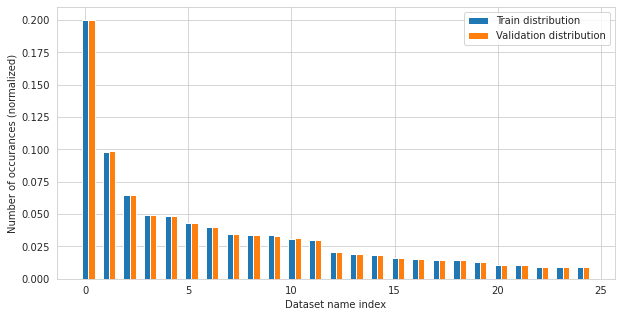

In [66]:
# Numbers of pairs of bars you want
N = 25

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, grouped_train['Label'].values, width, label='Train distribution')
plt.bar(ind + width, grouped_val['Label'].values, width, label='Validation distribution')

plt.xlabel('Dataset name index')
plt.ylabel('Number of occurances (normalized)')

plt.legend(loc='best')
plt.show()

In [67]:
train.to_csv("./train.csv")

In [68]:
validation.to_csv("./validation.csv")